### Evaluation of Generative Adveserial Network for Credit Card

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline

from keras import layers
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from pyod.models.mo_gaal import MO_GAAL
from pyod.utils.data import evaluate_print

from pprint import pprint
from time import time

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5
CKP_PREFIX = 'KDD_'

np.random.seed(RANDOM_STATE)

# pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1. Prepare data & Partition the data into 80-20 train-test split

Label Mapping: {'attack': 0, 'normal': 1}
Normal Label: 1
Attack Label: 0


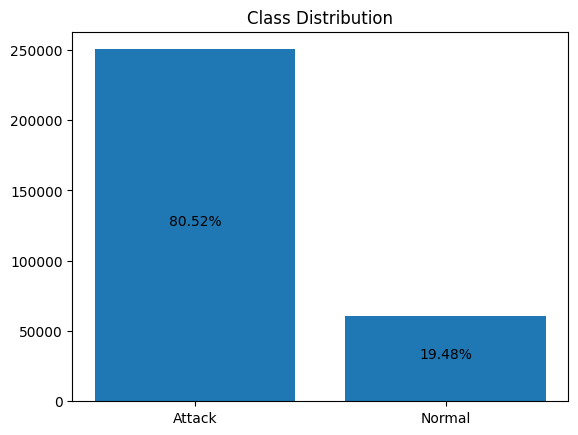

Percentage of outliers (contamination) in training set: 19.48%


In [7]:
# Importing the dataset
path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# Label encoding
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')
le = LabelEncoder()
y = le.fit_transform(data["label"])
X = data.drop("label", axis=1)

# Extract label mapping
label_mapping = {label: index for index, label in enumerate(le.classes_)}
normal_label = label_mapping['normal']
attack_label = label_mapping['attack']
print("Label Mapping:", label_mapping)
print("Normal Label:", normal_label)
print("Attack Label:", attack_label)

# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')
plt.title("Class Distribution")
plt.show()

# create training and test partitions with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Fit OneHotEncoder to learn categories from the training data. This is necessary to ensure that the same categories are used for random splits during cross-validation
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8")
one_hot_encoder.fit(X_train[categorical_cols])
learned_categories = one_hot_encoder.categories_

# Define numerical columns & indices
num_cols = data.drop(categorical_cols, axis=1)
num_indices = [data.columns.get_loc(col) for col in num_cols.drop('label', axis=1).columns]
cat_indices = [data.columns.get_loc(col) for col in categorical_cols]

# Define preprocessing transformers and pipeline

# Numerical transformer. Scales numerical data using StandardScaler
numeric_transformer = imblearn_pipeline(
    steps=[("scaler", StandardScaler())], verbose=True
)

# Categorical transformer. Encodes categorical data using OneHotEncoder
categorical_transformer = imblearn_pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
                categories=learned_categories,
                dtype="int8",
            ),
        )
    ],
    verbose=True,
)

# Define preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_indices),
        ("cat", categorical_transformer, cat_indices),
    ],
    verbose=True,
)


# print percentage of outliers 
contamination = y_train.sum() / len(y_train)
print(f'Percentage of outliers (contamination) in training set: {contamination * 100:.2f}%')

### 2. Define Models and Perform Cross-Validation on the training data

In [9]:
# Initialize cross-validation
kf = StratifiedKFold(n_splits=CROSS_VAL_SPLITS, shuffle=True, random_state=RANDOM_STATE)

f1_scores = []
precision_scores = []
recall_scores = []

# Define hyperparameters
EPOCHS=2
lr_discriminator = 0.01
lr_generator = 0.0001
N_SUB_GENERATORS = 3

# for train_index, val_index in kf.split(X_train, y_train):
for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    print(f"\nFold {i+1}/{CROSS_VAL_SPLITS}")

    X_train_fold = X_train.iloc[train_index].copy()
    y_train_fold = y_train[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_val_fold = y_train[val_index].copy()

    print("Fitting preprocessor...")
    # Fit preprocessor
    preprocessor.fit(X_train_fold)

    # transform data
    print("Transforming data...")
    X_train_fold = preprocessor.transform(X_train_fold)
    X_val_fold = preprocessor.transform(X_val_fold)
    print("Data transformed.")

    # check for nan
    print("nan values in X_train_fold: ", np.isnan(X_train_fold).any())

    # Define the classifier
    clf_name = 'MO_GAAL'
    clf = MO_GAAL(
        k=N_SUB_GENERATORS, # n of sub generators
        stop_epochs=EPOCHS,
        contamination=contamination, # percentage of outliers
        lr_d=lr_discriminator, # learning rate discriminator
        lr_g=lr_generator, # learning rate generator
    )

    
    print("Training Classifier...")
    # train MO_GAAL detector
    clf.fit(X_train_fold, y_train_fold)

    print("Predicting on validation set...")
    # Predict on validation set
    y_val_pred = clf.predict(X_val_fold)  # Predicted labels (0: inlier, 1: outlier)
    print("Predictions made.")

    print("Calculating metrics...")
    # Continuous scores from the discriminator
    anomalous_scores = clf.predict(X_val_fold[y_val_fold == attack_label])
    normal_scores = clf.predict(X_val_fold[y_val_fold == normal_label])

    # True labels
    y_true = np.concatenate([np.ones_like(anomalous_scores), np.zeros_like(normal_scores)])
    scores = np.concatenate([anomalous_scores, normal_scores])

    best_metric = 0
    best_threshold = 0

    # Calculate metrics
    for threshold in np.arange(0.1, 1, 0.001):
        current_metric = f1_score(y_true, scores < threshold)
        if current_metric > best_metric:
            best_metric = current_metric
            best_threshold = threshold

    # get all metrics
    f1 = f1_score(y_true, scores < best_threshold)
    precision = precision_score(y_true, scores < best_threshold)
    recall = recall_score(y_true, scores < best_threshold)

    print(f"current metrics: f1={f1:.4f}, precision={precision:.4f}, recall={recall:.4f}")

    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)


# Report mean and standard deviation of metrics
print("Cross-Validation Results:")
print(f"F1-Score: Mean={np.mean(f1_scores):.4f}, Std={np.std(f1_scores):.4f}")
print(
    f"Precision: Mean={np.mean(precision_scores):.4f}, Std={np.std(precision_scores):.4f}"
)
print(f"Recall: Mean={np.mean(recall_scores):.4f}, Std={np.std(recall_scores):.4f}")

# time per run: 


Fold 1/5
Fitting preprocessor...
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Transforming data...
Data transformed.
nan values in X_train_fold:  False
Training Classifier...
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Predicting on validation set...
Predictions made.
Calculating metrics...
current metrics: f1=0.7763, precision=0.7777, recall=0.7750

Fold 2/5
Fitting preprocessor...
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Transforming data...
Data transformed.
nan values in X_t

### 3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters

In [11]:
# Fit the preprocessor on the full training data
preprocessor.fit(X_train)

# Transform the filtered data without re-fitting
transformed_sample = preprocessor.transform(X_train)

clf_name = 'MO_GAAL'
clf = MO_GAAL(
    k=N_SUB_GENERATORS, # n of sub generators
    stop_epochs=EPOCHS,
    contamination=contamination, # percentage of outliers
    lr_d=lr_discriminator, # learning rate discriminator
    lr_g=lr_generator, # learning rate generator
)

print("Training Classifier...")
# train MO_GAAL detector
clf.fit(transformed_sample, y_train)

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.1s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Training Classifier...
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6


MO_GAAL(contamination=0.19481318045357543, k=3, lr_d=0.01, lr_g=0.0001,
    momentum=0.9, stop_epochs=2)

### 4. Final evaluation of the models on test set

In [12]:
transformed_test = preprocessor.transform(X_test)

print("Predicting on tet set...")
y_val_pred = clf.predict(transformed_test)  # Predicted labels (0: inlier, 1: outlier)
print("Predictions made.")

print("Calculating metrics...")
# Continuous scores from the discriminator
anomalous_scores = clf.predict(transformed_test[y_test == attack_label])
normal_scores = clf.predict(transformed_test[y_test == normal_label])

# True labels
y_true = np.concatenate([np.ones_like(anomalous_scores), np.zeros_like(normal_scores)])
scores = np.concatenate([anomalous_scores, normal_scores])

best_metric = 0
best_threshold = 0

# Calculate metrics
for threshold in np.arange(0.1, 1, 0.001):
    current_metric = f1_score(y_true, scores < threshold)
    if current_metric > best_metric:
        best_metric = current_metric
        best_threshold = threshold

# get all metrics
f1 = f1_score(y_true, scores < best_threshold)
precision = precision_score(y_true, scores < best_threshold)
recall = recall_score(y_true, scores < best_threshold)

print(f"current metrics: f1={f1:.4f}, precision={precision:.4f}, recall={recall:.4f}")

Predicting on tet set...
Predictions made.
Calculating metrics...
current metrics: f1=0.7743, precision=0.7735, recall=0.7751


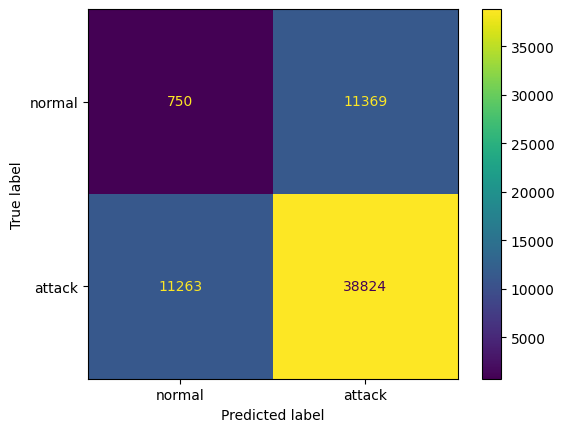

In [13]:
# confusion matrix
cm = confusion_matrix(y_true, scores < best_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'attack'])
disp.plot()
plt.show()